<center><img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F450%2F1*CXZ804tKLPy2hiikJbYH3w.png&f=1&nofb=1" width=30% ></center>

# <center> Assignment 4: Image Alignment and Stitching </center>
<center> Computer Vision 1, University of Amsterdam </center>
    <center> Due 23:59, October 8, 2022 (Amsterdam time) </center>
    
***

## General guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 4 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows: **StudentID1_StudentID2_StudentID3.zip**. For full credit, make sure your answers follow these guidelines:
- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=cv1lab4.yaml`, then activate it as `conda activate cv1lab4`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the report self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade.

**Late submissions are not allowed**. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs' system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

**Plagiarism note**: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

****

In [6]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

In [7]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.


# Image Alignment (60pts)

In this practice, you will write a function that takes two images as
input and computes the affine transformation between them. You will work
with supplied images. The overall scheme is as follows:

  1.  Detect interest points in each image.

  2.  Characterize the local appearance of the regions around interest
      points.

  3.  Get the set of supposed matches between region descriptors in each
      image.

The first three steps can be performed using David Lowe's SIFT. Check
out the Docs of SIFT related function for further information in the
following link:
<https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html> and
<https://docs.opencv.org/3.4.9/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html>.

4.  Perform RANSAC to discover the best transformation between images. RANSAC should be performed as follows:

  -   Repeat $N$ times:

  -   Pick $P$ matches at random from the total set of matches $T$.

  -   Construct a matrix $A$ and vector $b$ using the $P$ pairs of points and find affine transformation parameters $(m1, m2, m3, m4, t1, t2)$ (see [Question 2.1](#q2.1)) by solving the equation $Ax = b$. Such equation can be solved using the pseudo-inverse: $x = (A^T A)^{-1} A^T b$, or packages of Numpy in Python.

  - Using the transformation parameters, transform the locations of all $T$ points in image1. If the transformation is correct, they should lie close to their counterparts in image2. Plot the two images side by side with a line connecting the original $T$ points in image1 and transformed $T$ points over image2.
      
  - Count the number of inliers, where inliers are defined as the number of transformed points from image1 that lie within a radius of $10$ pixels of their pair in image2.

  - If this count exceeds the best total so far, save the transformation parameters and the set of inliers.

  - End repeat.

5. Finally, transform image1 using this final set of transformation parameters. If you display this image, you should find that the pose of the object in the scene should correspond to its pose in image2. To transform the image, implement your own function based on **nearest-neighbor interpolation**. Then use the OpenCV built-in function `cv2.warpAffine` and compare your results.<br>
Note, nearest neighbors does not mean you have to classify points. The problem is that if you have a transformation, then the transformed points may not be at perfect pixels (e.g., 0.3px). Instead of linear interpolation, which requires more work to implement, we can just use nearest neighbors which means simply **rounding the coordinates**.

## Question 1

### Question 1.1

Create a function that takes image pairs `street1.png` and `street2.png` as input,and return the keypoint matchings between the two images. <br><br>
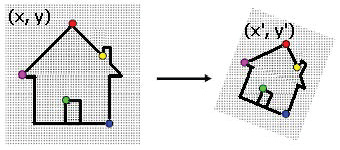

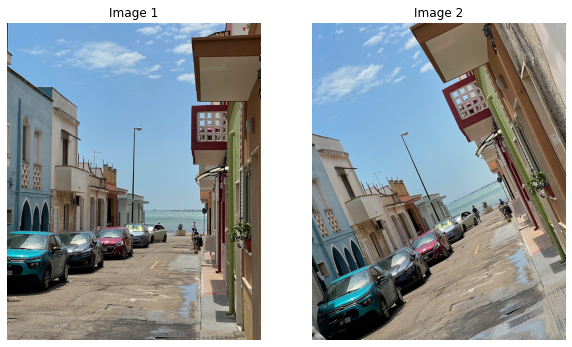

In [8]:
img1_path = "street1.png" 
img2_path = "street2.png"

# Open images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Note: OpenCV uses BGR instead of RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display images
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('Image 1')
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Image 2')
plt.show()
plt.close()

**Note:** For some patent issue, the newest version of OpenCV does not contain SIFT-related function. Therefore, the provided environment uses an older version of the pacakge (`opencv-contrib-python==3.4.2.17`). If you can't run the cell below, make sure you are using the `cv1` python environment.

**<font color=green > Question - 1.1 answer**

In [9]:
def keypoint_matching(image1, image2):
    """
    Given two input images, find and return the matching keypoints.
    Arguments:
    image1: the first image (in RGB)
    image2: the second image (in RGB)
    Returns: 
    The keypoints of image1, the keypoints of image2 and the matching
    keypoints between the two images
    """
    print('\nFinding matching features...')

    # Initialize sift algorithm
    sift = cv2.xfeatures2d.SIFT_create()
    
    # Detect the keypoints
    keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)
    
    # Find the matching keypoints using K-nearest neighbours and a ratio test
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
    
    # Apply ratio test to find the best matches
    best_matches = []
    
    for m, n in matches:
        if m.distance < 0.80 * n.distance:
            best_matches.append([m])

    # Print the statistics
    print("Number of keypoints in img1:        ", len(keypoints_1))
    print("Number of keypoints in img2:        ", len(keypoints_2))
    print("Number of keypoints after matching: ", len(best_matches), "\n")

    return keypoints_1, keypoints_2, best_matches

In [10]:
# Find and match key points
keypoints_1, keypoints_2, matches = keypoint_matching(img1,img2)


Finding matching features...
Number of keypoints in img1:         1987
Number of keypoints in img2:         2110
Number of keypoints after matching:  807 



### Question 1.2
Take a random subset (with set size set to 10) of all matching points, and plot on the image. Connect matching pairs with lines. You can assign a random color to each line to make them easier to distinguish.

**<font color=green > Question - 1.2 answer**

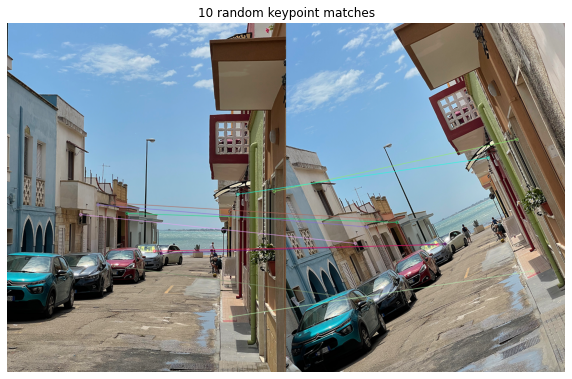

In [11]:
# Extract 10 random matches to plot
random_matches = [matches[i] for i in random.sample(range(0, len(matches)), 10)]

# Now plot them. Hint: for generating the plot, you can use cv2.drawMatches()

# Create the figure
img3 = cv2.drawMatchesKnn(img1, keypoints_1, img2, keypoints_2, random_matches,
                          None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10,8))

# Layout of the figure
plt.axis('off')
plt.title('10 random keypoint matches')

# Display the random keypoint matches
plt.imshow(img3),
plt.show();

### Question 1.3
Create a function that performs the RANSAC algorithm as explained above. The function should return the best transformation found. For visualization, show the transformations from image1 to image2 and from image2 to image1.

**<font color=green > Question - 1.3 answer**

In [12]:
# Self-designed functions 'get_grid' and 'affine_transform' for ranasc algorithm.
def get_grid(h, w):
    # Generates HOMOGENEOUS coordinates of an image in a grid-like fashion.
    
    # Initialize a grid
    grid = np.zeros((h, w, 3))
    
    # For all the rows
    for row in range(h):
        # For all the cols
        for col in range(w):
            grid[row][col] = [col, row, 1]
            
    return np.array(grid.astype(int))

In [13]:
# Helper function that rounds the pixel indices to perform interpolation

def nearest_neighbour(new_coord, img):
    row = new_coord[1]
    col = new_coord[0]
    
    # Both row and col indices are integers
    if np.floor(row) == row and np.floor(col) == col:
        row, col = int(row), int(col)
        
    # Pick the closer indices for col indices if they are not integers
    if np.abs(np.floor(col) - col) < np.abs(np.ceil(col) - col):
        col = int(np.floor(col))
    else:
        col = int(np.ceil(col))
        
    # Do the same for row index
    if np.abs(np.floor(row) - row) < np.abs(np.ceil(row) - row):
        row = int(np.floor(row))
    else:
        row = int(np.ceil(row))
    
    return row, col

In [19]:
def affine_transform(img, mat, warp='forward'):
    #Applies the affine transformation defined in mat to the image contained in img.
    #Works in homogeneous coordinates.
    """
    Arguments:
    img: the first/second image (img1 or img2)
    mat: transformation matrix
    warp: forward or inverse warping
    Returns:
    transformed image
    """
    
    # Initialize the transformed image
    h, w, _ = img.shape
    output = np.zeros((h, w, 3), dtype=np.uint8)
    
    # Create the grid homogeneous coordinates
    grid = get_grid(h, w)

    # Calculate the new pixel values of the created grid
    if warp =='forward':
        for row in range(h):
            for col in range(w):
                # Get the coordinates
                coord = grid[row, col]
                
                # Find the new coordinates
                new_coord = mat @ coord
                
                # round the indices
                new_row, new_col = nearest_neighbour(new_coord, img)
                    
                # Discard if the pixel is outside of image boundaries
                if new_col < w and new_row < h and new_col > 0 and new_row > 0:
                    output[new_row, new_col] = img[row, col]
  
    if warp == 'inverse':
        mat_inv = np.linalg.inv(mat)
        for row in range(h):
            for col in range(w):
                coord = grid[row, col]
                
                new_coord = mat_inv@coord
                
                new_row, new_col = nearest_neighbour(new_coord, img)
                
                if new_col < w and new_row < h and new_row > 0 and new_col > 0:
                    output[row, col] = img[new_row, new_col]

    return output

In [15]:
# Helper function that helps calculate the a, b matrices used to calculate 
# the transformation parameters

def get_matrices(match, keypoints_1, keypoints_2):
    # Get the original coordinates
    idx_img1 = match[0].queryIdx
    kp1_coords = keypoints_1[idx_img1].pt
    
    # Get the new coordinates
    idx_img2 = match[0].trainIdx
    kp2_coords = keypoints_2[idx_img2].pt    
    
    # Find one 'row' of the A matrix and b vector
    a = np.array([[kp1_coords[0], kp1_coords[1], 0, 0, 1, 0], [0, 0, kp1_coords[0], kp1_coords[1], 0, 1]])
    b = np.array([[kp2_coords[0]], [kp2_coords[1]]])

    return a, b

In [16]:
def ransac(kp1, kp2, matches, N):
    """
    Arguments:
      kp1: the keypoints of image1, 
      kp2: the keypoints of image2
      matches: the matching keypoints between the two images
      N: number of iterations
    Returns: 
      the best transformation matrix
    """
    
    # First initialize the best inliers at 0 (worst case)
    best_inliers = 0
    
    # Pick amount of random matches
    P = 10
    
    # Loop N times over your ransac
    for iteration in range(N):
        
        # Pick P number of random matches
        random_matches = [matches[i] for i in random.sample(range(0, len(matches)), P)]
        
        # Initialize the A matrix and b vecotr
        A, b = get_matrices(random_matches[0], kp1, kp2)

        # For all matches, concatenate them to the A matrix and b vector vertically
        for match in random_matches[1:]:
            A = np.concatenate((A, get_matrices(match, kp1, kp2)[0]), axis=0)
            b = np.concatenate((b, get_matrices(match, kp1, kp2)[1]), axis=0)

        # Calculate x (transformation parameters: m1, m2, m3, m4, t1, t2)
        x = np.linalg.inv(A.T @ A) @ A.T @ b
        
        # The rotation part of the transformation parameters
        rotation_matrix = np.array([[x[0][0], x[1][0]], [x[2][0], x[3][0]]])
        
        # The translation part of the transformation parameters
        translation_matrix = np.array([[x[4][0]], [x[5][0]]])

        # Initialize a counter keeping track of the inliers
        inliers = 0

        # For all matches calculate their new coordinates
        for match in matches:
            
            # Get the original coordinates of a match
            idx_img1 = match[0].queryIdx
            kp1_coords = kp1[idx_img1].pt
            kp1_coords = np.array([[kp1_coords[0]], [kp1_coords[1]]])
            
            # Calculate its new coordinates
            new_coords = rotation_matrix @ kp1_coords + translation_matrix
            
            # Get the actual new coordinates
            idx_img2 = match[0].trainIdx
            kp2_coords = kp2[idx_img2].pt

            # Calculate the distance between the predicted and actual coordinates
            distance = np.sqrt((kp2_coords[0] - new_coords[0][0])**2 + (kp2_coords[1] - new_coords[1][0])**2)

            # Inlier when distance is smaller than 10 pixels
            if distance <= 10:
                inliers += 1

        # If our amount of inliers is highest, store our inlier amount and transformation parameters
        if inliers > best_inliers:
            best_inliers = inliers
            best_matrix = x
            
    # Print results
    print("Total number of matches: ", len(matches))
    print("Inliers found:           ", best_inliers)
    print("Outliers removed:        ", len(matches) - best_inliers)
    
    # Use parameters to create best_matrix
    best_matrix = best_matrix.flatten()
    best_matrix = np.array([[best_matrix[0], best_matrix[1], best_matrix[4]], 
                   [best_matrix[2], best_matrix[3], best_matrix[5]],
                   [0, 0, 1]])
    
    return best_matrix

In [17]:
def visualization(img, best_matrix):
    """
      Arguments:
        img: the first/second image (img1 or img2)
        best_matrix: the best transformation matrix
    """  
    # Visualize/export a comparison: "Forward warping", "Inverse warping", 
    # "OpenCV warping", "Original image". Refer to the output of the next
    # cell to see the expected output.
    
    # Alter the best_matrix for the open_cv use:
    best_matrix_cv = best_matrix[:-1, :]
    
    # Visualization of the forward warp
    forward_warp = affine_transform(img, best_matrix)
    
    # Visualization of the inverse warp
    inverse_warp = affine_transform(img, best_matrix, warp='inverse')

    # Visualization of the cv2 warp Affine function
    opencv_warp = cv2.warpAffine(img, best_matrix_cv, (img.shape[1], img.shape[0]))
    
    # Create figure
    fig = plt.figure(figsize=(20,10))
    
    # Setting values to rows and column variables
    rows = 1
    columns = 4
    
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # Display forward warp
    plt.imshow(forward_warp)
    plt.axis('off')
    plt.title("Forward warping")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # Display inverse warp
    plt.imshow(inverse_warp)
    plt.axis('off')
    plt.title("Inverse warping")

    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)

    # Display OpenCV warp
    plt.imshow(opencv_warp)
    plt.axis('off')
    plt.title("OpenCV Warping")

    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)

    # Display original image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original image")
    
    return

Total number of matches:  807
Inliers found:            749
Outliers removed:         58


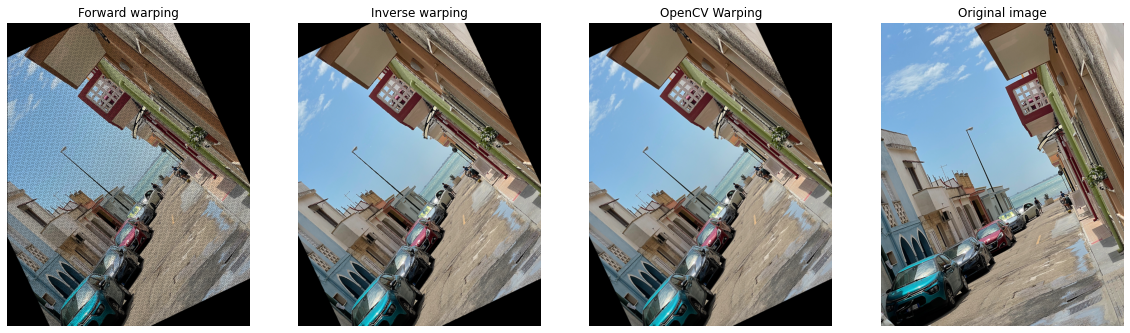

In [20]:
N_iterations = 10 # experiment with this value!
best_matrix = ransac(keypoints_1,keypoints_2,matches, N_iterations)
visualization(img2, best_matrix)

## Question 2
Based on the results, answer the following questions.

<a name="q2.1"></a>
### Question 2.1
How many matches do we need to solve an affine transformation which can be formulated as follows:

$$
\begin{bmatrix}
x'\\y'\end{bmatrix} =
\begin{bmatrix}
m_1 & m_2\\
m_3 & m_4
\end{bmatrix}
\begin{bmatrix}
x\\y\end{bmatrix}+
\begin{bmatrix}
t_1\\t_2\end{bmatrix}
$$

The equation above can be rewritten as:

$$
\begin{bmatrix}
x&y&0&0&1&0\\
0&0&x&y&0&1\end{bmatrix}
\begin{bmatrix}
m_1\\
m_2\\
m_3\\
m_4\\
t_1\\
t_2
\end{bmatrix} =
\begin{bmatrix}
x'\\y'\end{bmatrix}
$$
or, alternatively:
$$
Ax=b, \;
A = \begin{bmatrix}
x&y&0&0&1&0\\
0&0&x&y&0&1\end{bmatrix}, \;
x = \begin{bmatrix}
m_1\\
m_2\\
m_3\\
m_4\\
t_1\\
t_2
\end{bmatrix}, \;
b = \begin{bmatrix}
x'\\y'\end{bmatrix}
$$

**ADD YOUR ANSWER HERE**

### Question 2.2
How many iterations in average are needed to find good transformation parameters?

**ADD YOUR ANSWER HERE**

____

# Image Stitching (40pts)

In this practice, you will write a function that takes two images as input and stitch them together. The method described in the previous section will be used to stitch two images together by transforming one of them to the coordinate space of the other. You will work with supplied images *left.jpg* and *right.jpg*. The overall scheme can be summarized as follows:

1.   As in previous task you should first find the best transformation between input images.

2.   Then you should estimate the size of the stitched image.

3.   Finally, combine the *left.jpg* with the transformed *right.jpg* into one image.

## Question 3
### Question 3.1 
Create a function that takes an image pair as input, and return the stitched version.




In [138]:
def calc_stitched_size(left_image, right_image, best_matrix):
    h1, w1 = left_image.shape[:2]
    h2, w2 = right_image.shape[:2]
    
    # we use math form (x=w, y=h, z), NOT numpy indexing such as (row, col)
    right_corners = np.array([[0, 0, 1], [0, h2, 1], [w2, 0, 1], [w2, h2, 1]])
    left_corners = np.array([[0, 0, 1], [0, h1, 1], [w1, 0, 1], [w1, h1, 1]])
    
    # transform the corners of the right image
    trans_right_corners = np.array([np.round(best_matrix @ corner) for corner in right_corners])

    all_corners = np.concatenate((left_corners, trans_right_corners), axis=0)
    new_h = np.max(all_corners[:,1]) + np.abs(np.min(all_corners[:,1]))
    new_w = np.max(all_corners[:,0]) + np.abs(np.min(all_corners[:,0]))

    return int(new_h), int(new_w)

In [152]:
def stitch(image1, image2, new_height, new_width, best_matrix):
    h1, w1 = image1.shape[:2] # left image
    h2, w2 = image2.shape[:2] # right image
    stitched_image = np.zeros((new_height, new_width, 3), dtype=np.uint8) # 3 is for RGB channels
    
    
    for row in range(new_height):
        for col in range(new_width):
            
            # first append left image
            if row < h1 and col < w1: 
        
                stitched_image[row, col] = image1[row, col]
                
            # for the rest, if exists, add pixel values from right image
            else:
                # inverse warping to find the original pixels 
                # the best matrix is the inverse of the matrix transforming left image to the right
                # remember to always use math def (x, y, z) not numpy (row, col)
                origin_coords = best_matrix @ np.array([(col), (row), 1]) 
                # interpolation using nearest neighbour function used for RANSAC visualization
                origin_row, origin_col = nearest_neighbour(origin_coords, img2)

                if 0 <= origin_row < h2 and 0 <= origin_col < w2:
                    stitched_image[row, col] = image2[np.abs(origin_row), np.abs(origin_col)]
    return stitched_image

In [153]:
def stitchImages(img1, img2, N):
    """
    Given two input images, return the stitched image.
    Arguments:
      img1: the first image (in RGB)
      img2: the second image (in RGB)
    Returns: 
      The keypoint matchings between the two image
    """

    # Step 1: Find the best transformation
    
    # Find the matching keypoints
    kp1, kp2, matches = keypoint_matching(img1, img2)
    
    # Use Ransac to find best transformation matrix
    best_matrix = ransac(kp1, kp2, matches, N)
    
    # Step 2: Estimate the size of the stitched image.
    # Hint: Calculate the transformed coordinates of corners of the *right.jpg*
    new_height, new_width = calc_stitched_size(img1, img2, best_matrix)
   
    # Step 3: Combine the *left.jpg* with the transformed *right.jpg* into one image.
    stitched_image = stitch(img1, img2, new_height, new_width, best_matrix)
    
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.imshow(stitched_image)
    
    return stitched_image


Finding matching features...
Number of keypoints in img1:         709
Number of keypoints in img2:         881
Number of keypoints after matching:  101 

Total number of matches:  101
Inliers found:            83
Outliers removed:         18


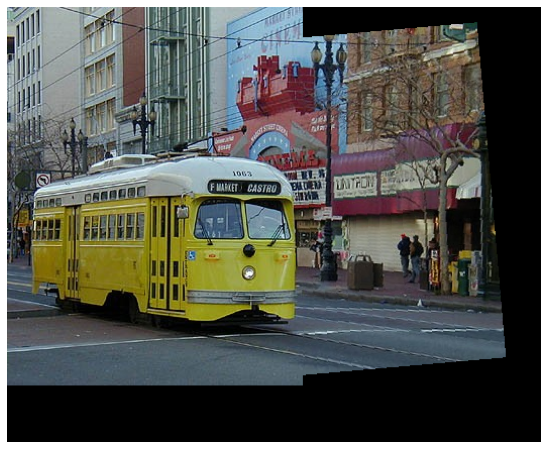

In [154]:
img1_path = "left.jpg"
img2_path = "right.jpg"

# Load images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Note: OpenCV uses BGR instead of RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

stitched_image = stitchImages(img1, img2, 100)

### Question 3.2
Visualize the stitched image alongside with the image pair.

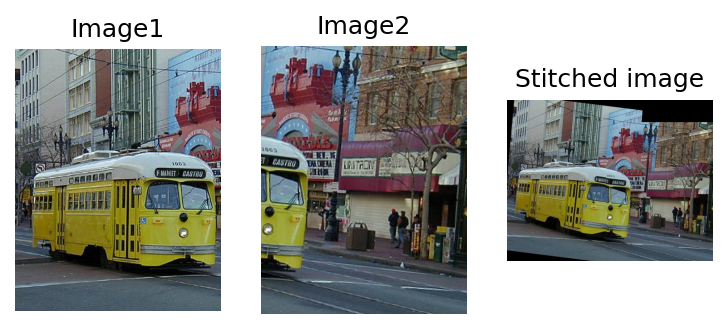

In [20]:
# TODO: Visualize the stitched image alongside with the image pair.

# ================
# Your code here
# ================